# **Dependencies**

In [5]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 54.6 MB/s eta 0:00:00


# **Imports**

In [10]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# **Data Information**

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Finance Tracker/Finance_MayJunJul.xlsx')
# View data
df

,seq,page,line,date,date_str,description,amount,balance,source_file,month
0,1,1,20,2025-05-15,15/05,CDM CASH DEPOSIT,50.00,50.00,Statement_May 2025.pdf,2025-05
1,2,1,21,2025-05-15,15/05,SALE DEBIT | MARRYBROWN - SRI SE*,-6.90,43.10,Statement_May 2025.pdf,2025-05
2,3,1,24,2025-05-15,15/05,SALE DEBIT | RAPID RAIL-MRT KGL *,-10.00,33.10,Statement_May 2025.pdf,2025-05
3,4,1,27,2025-05-15,15/05,TRANSFER TO A/C | MOHAMMAD JAVAN SAMB*,766.90,800.00,Statement_May 2025.pdf,2025-05
4,5,1,29,2025-05-15,15/05,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,-700.00,100.00,Statement_May 2025.pdf,2025-05
...,...,...,...,...,...,...,...,...,...,...
91,40,4,28,2025-07-30,30/07,PAYMENT VIA MYDEBIT | MBF *,-55.00,932.49,Statement_July 2025.pdf,2025-07
92,41,4,31,2025-07-30,30/07,PAYMENT VIA MYDEBIT | CIMB BANK BERHAD *,-37.80,894.69,Statement_July 2025.pdf,2025-07
93,42,4,34,2025-07-31,31/07,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,-79.85,814.84,Statement_July 2025.pdf,2025-07
94,43,4,38,2025-07-31,31/07,SALE DEBIT | PSS-SRI KEMBANGAN *,-5.00,809.84,Statement_July 2025.pdf,2025-07


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   seq          96 non-null     int64         
 1   page         96 non-null     int64         
 2   line         96 non-null     int64         
 3   date         96 non-null     datetime64[ns]
 4   date_str     96 non-null     object        
 5   description  96 non-null     object        
 6   amount       96 non-null     float64       
 7   balance      96 non-null     float64       
 8   source_file  96 non-null     object        
 9   month        96 non-null     object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.6+ KB


,seq,page,line,date,amount,balance
count,96.000000,96.000000,96.000000,96,96.000000,96.000000
mean,17.885417,2.031250,34.343750,2025-06-22 16:45:00,8.177917,597.839479
min,1.000000,1.000000,18.000000,2025-05-15 00:00:00,-707.160000,10.000000
25%,8.750000,1.000000,25.750000,2025-06-01 18:00:00,-40.250000,100.000000
50%,16.500000,2.000000,34.000000,2025-06-27 00:00:00,-14.500000,742.295000
75%,26.000000,3.000000,41.250000,2025-07-15 06:00:00,-0.500000,883.672500
max,44.000000,4.000000,53.000000,2025-07-31 00:00:00,1400.000000,1420.840000
std,11.419162,0.967396,10.160634,NaN,268.446512,398.668863


In [ ]:
df.isnull().sum()

,0
seq,0
page,0
line,0
date,0
date_str,0
description,0
amount,0
balance,0
source_file,0
month,0


# **Data Preprocessing**

**Ordering**

In [ ]:
# Ensure required columns exist
required = {"date","description","amount"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in Combined: {missing}")

# Coerce date to datetime; trim to date only (drop time)
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date

# If month column not present, create it for ordering; then sort by month → existing seq (if any)
if "month" not in df.columns:
    df["month"] = pd.to_datetime(df["date"]).astype("datetime64[ns]").dt.to_period("M").astype(str)

# If seq missing, create a temporary one in the current row order
if "seq" not in df.columns:
    df["seq"] = np.arange(1, len(df)+1)

# Sort by month then seq to preserve statement order within each month
df = df.sort_values(["month","seq"]).reset_index(drop=True)

# Rebuild a unified seq from 1..N across ALL rows (your request)
df["seq"] = np.arange(1, len(df)+1)

# View changes
df

,seq,page,line,date,date_str,description,amount,balance,source_file,month
0,1,1,20,2025-05-15,15/05,CDM CASH DEPOSIT,50.00,50.00,Statement_May 2025.pdf,2025-05
1,2,1,21,2025-05-15,15/05,SALE DEBIT | MARRYBROWN - SRI SE*,-6.90,43.10,Statement_May 2025.pdf,2025-05
2,3,1,24,2025-05-15,15/05,SALE DEBIT | RAPID RAIL-MRT KGL *,-10.00,33.10,Statement_May 2025.pdf,2025-05
3,4,1,27,2025-05-15,15/05,TRANSFER TO A/C | MOHAMMAD JAVAN SAMB*,766.90,800.00,Statement_May 2025.pdf,2025-05
4,5,1,29,2025-05-15,15/05,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,-700.00,100.00,Statement_May 2025.pdf,2025-05
...,...,...,...,...,...,...,...,...,...,...
91,92,4,28,2025-07-30,30/07,PAYMENT VIA MYDEBIT | MBF *,-55.00,932.49,Statement_July 2025.pdf,2025-07
92,93,4,31,2025-07-30,30/07,PAYMENT VIA MYDEBIT | CIMB BANK BERHAD *,-37.80,894.69,Statement_July 2025.pdf,2025-07
93,94,4,34,2025-07-31,31/07,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,-79.85,814.84,Statement_July 2025.pdf,2025-07
94,95,4,38,2025-07-31,31/07,SALE DEBIT | PSS-SRI KEMBANGAN *,-5.00,809.84,Statement_July 2025.pdf,2025-07


**Remove unecessary columns**

In [ ]:
for col in ["page","line","source_file","month","date_str"]:
    if col in df.columns:
        df = df.drop(columns=col)

print("Rows:", len(df))
df.head(10)

Rows: 96


,seq,date,description,amount,balance
0,1,2025-05-15,CDM CASH DEPOSIT,50.0,50.0
1,2,2025-05-15,SALE DEBIT | MARRYBROWN - SRI SE*,-6.9,43.1
2,3,2025-05-15,SALE DEBIT | RAPID RAIL-MRT KGL *,-10.0,33.1
3,4,2025-05-15,TRANSFER TO A/C | MOHAMMAD JAVAN SAMB*,766.9,800.0
4,5,2025-05-15,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,-700.0,100.0
5,6,2025-05-16,ANNUAL FEES FOR BANKARD CHA,-8.0,92.0
6,7,2025-05-17,TRANSFER TO A/C | MOHAMMAD JAVAN SAMB*,8.0,100.0
7,8,2025-05-19,SALE DEBIT | GRAB RIDES-EC *,-1.0,99.0
8,9,2025-05-19,SALE DEBIT | GRAB RIDES-EC *,-7.0,92.0
9,10,2025-05-19,REFUND SALE | GRAB RIDES-EC *,1.0,93.0


**Description Cleaning and Categorizing**

In [ ]:
# --- Unify naming of descriptions ---
SPACE = re.compile(r"\s+")
STARJUNK = re.compile(r"\*+")
DIGIT_NOISE = re.compile(r"\b\d{6,}\b")
CCY_NOISE  = re.compile(r"\b[A-Z]{2,3}\s*\d[\d,\.]*")
TRAIL_BARS = re.compile(r"[|]+$")


def clean_text_base(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()

    # Generic noise
    s = re.sub(r"\*+", "", s)                               # remove asterisks
    s = re.sub(r"\b[A-Z]{2,3}\s*\d[\d,\.]*", "", s)         # currency-like tokens
    s = re.sub(r"\b\d{6,}\b", "", s)                        # long numeric IDs
    s = re.sub(r"[|]+$", "", s)                             # trailing pipes
    s = re.sub(r"\s+", " ", s)

    # Normalization rules
    # CDM CASH DEPOSIT -> CASH DEPOSIT
    s = re.sub(r"^CDM\s+CASH\s+DEPOSIT", "CASH DEPOSIT", s, flags=re.I)

    # Remove SALE DEBIT | ...
    s = re.sub(r"^SALE\s+DEBIT\s*\|\s*", "", s, flags=re.I)

    # Remove PRE-AUTH DEBIT | ...
    s = re.sub(r"^PRE-AUTH\s+DEBIT\s*\|\s*", "", s, flags=re.I)

    # Remove PAYMENT VIA MYDEBIT | ...
    s = re.sub(r"^PAYMENT\s+VIA\s+MYDEBIT\s*\|\s*", "", s, flags=re.I)

    # TRANSFER TO A/C | <name> -> TRANSFER TO A/C
    s = re.sub(r"^TRANSFER\s+TO\s+A/C\s*\|.*", "TRANSFER TO A/C", s, flags=re.I)

    # TRANSFER FR A/C | <name> -> TRANSFER FR <name>
    s = re.sub(r"^TRANSFER\s+FR\s+A/C\s*\|\s*(.+)", r"TRANSFER FR \1", s, flags=re.I)

    return s.strip()

def _normalize_vendor(v: str) -> str:
    v = v.strip()
    v = re.sub(r"\*+", "", v)               # remove asterisks
    v = v.split("/")[0]                     # drop URL paths: BOLT.EU/O/... -> BOLT.EU
    v = re.sub(r"\s*\d+\s*$", "", v)        # drop trailing numeric IDs
    v = re.sub(r"\s*,?\s*(MY|MYS|SG|US)\s*$", "", v, flags=re.I)  # drop country codes
    v = re.sub(r"\s+", " ", v)
    return v.strip()

def normalize_refund(desc: str) -> str:
    """Turn refund line into 'REFUND | Vendor'."""
    if not isinstance(desc, str):
        return ""
    up = desc.upper()
    if "REFUND" not in up:
        return desc

    # Unify leading tokens to 'REFUND | ...'
    tmp = re.sub(r"^(REFUND(?:\s+SALE)?|PRE-AUTH\s+REFUND)\s*\|\s*", "REFUND | ", desc, flags=re.I)
    m = re.match(r"^REFUND\s*\|\s*(.+)$", tmp, flags=re.I)
    if not m:
        return desc

    tail = m.group(1)
    vendor_block = tail.split("|")[0].strip()   # take the first block after REFUND |
    vendor = _normalize_vendor(vendor_block)

    return f"REFUND | {vendor}" if vendor else "REFUND"

# Keep raw + cleaned
df["raw_description"] = df["description"].astype(str)
df["clean_description"] = df["raw_description"].map(clean_text_base)
df["clean_description"] = df["clean_description"].map(normalize_refund)

# Transaction type
df["type"] = np.where(df["amount"] > 0, "Income",
               np.where(df["amount"] < 0, "Expense", "Neutral"))

# --- Category rules (with your earlier choices; Rent stays specific) ---
specific_rules = [
    # Rent/Housing when outgoing transfer to RAMADHAN MOCHAMAD R >= 700
    (re.compile(r"TRANSFER\s+FR\s+RAMADHAN\s+MOCHAMAD\s+R", re.I),
     lambda row: "Rent/Housing" if (row["amount"] <= -700) else None),
]

general_rules = [
    (re.compile(r"\bDEPOSIT\b|\bDIVIDEND PAID\b|\bTRANSFER TO A/C\b", re.I), lambda r: "Income"),
    (re.compile(r"\bWITHDRAWAL/FASTCASH\b", re.I),                             lambda r: "Cash/ATM"),
    (re.compile(r"\bTRANSFER FR\b|\bPAYMENT FR A/C\b", re.I),                 lambda r: "Transfers"),
    (re.compile(r"HoYoverse|STEAMGAMES\.COM|Steam|TURBO\s*LEARN", re.I),      lambda r: "Online Purchase"),
    (re.compile(r"Booking\.com|Partners on Booking", re.I),                   lambda r: "Travel"),
    (re.compile(r"\bShopee\b|Shopee Malaysia|Uniqlo", re.I),                  lambda r: "Shopping"),
    (re.compile(r"ZUS COFFEE|AUNTIE ANNE|DUNKIN|MAKAN PAGI|BAKER'S COTTAGE|FOWLBOYS|MARRYBROWN|SUMMATION", re.I),
                                                                            lambda r: "Food & Beverage"),
    (re.compile(r"GRAB RIDES|GRABEXPRESS|RAPID RAIL|MRT|PUTRAJAYA SENTRAL|BOLT\.EU", re.I),
                                                                            lambda r: "Transport"),
    (re.compile(r"Maxis|HOTLINK|Yes\b|BANKARD", re.I),                        lambda r: "Bills & Utilities"),
    (re.compile(r"CIMB BANK BERHAD|PUBLIC BANK BERHAD|PSS-SRI KEMBANGAN|PASAR MINI", re.I),
                                                                            lambda r: "Shopping"),
    (re.compile(r"\bRENT\b|\bLANDLORD\b|APARTMENT|CONDO MGMT FEE", re.I),     lambda r: "Rent/Housing"),
]

def categorize_row(row) -> str:
    txt = row["clean_description"]
    for rx, fn in specific_rules:
        if rx.search(txt):
            cat = fn(row)
            if cat:
                return cat
    for rx, fn in general_rules:
        if rx.search(txt):
            return fn(row)
    if row["type"] == "Income":
        return "Income"
    if row["type"] == "Expense":
        return "Uncategorized"
    return "Neutral"

df["category"] = df.apply(categorize_row, axis=1)

# Big expense (fixed threshold ≥ 100)
threshold = 100
df["big_expense"] = (df["amount"] < 0) & (df["amount"].abs() >= threshold)
print(f"Big expense threshold: {threshold}")

# Final tidy columns
cols = ["seq","date","raw_description","clean_description","category","type","amount","big_expense"]
if "balance" in df.columns:
    cols.append("balance")
df_clean = df[cols].copy()

df_clean.head(10)


Big expense threshold: 100


,seq,date,raw_description,clean_description,category,type,amount,big_expense,balance
0,1,2025-05-15,CDM CASH DEPOSIT,CASH DEPOSIT,Income,Income,50.0,False,50.0
1,2,2025-05-15,SALE DEBIT | MARRYBROWN - SRI SE*,MARRYBROWN - SRI SE,Food & Beverage,Expense,-6.9,False,43.1
2,3,2025-05-15,SALE DEBIT | RAPID RAIL-MRT KGL *,RAPID RAIL-MRT KGL,Transport,Expense,-10.0,False,33.1
3,4,2025-05-15,TRANSFER TO A/C | MOHAMMAD JAVAN SAMB*,TRANSFER TO A/C,Income,Income,766.9,False,800.0
4,5,2025-05-15,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,TRANSFER FR RAMADHAN MOCHAMAD R,Rent/Housing,Expense,-700.0,True,100.0
5,6,2025-05-16,ANNUAL FEES FOR BANKARD CHA,ANNUAL FEES FOR BANKARD CHA,Bills & Utilities,Expense,-8.0,False,92.0
6,7,2025-05-17,TRANSFER TO A/C | MOHAMMAD JAVAN SAMB*,TRANSFER TO A/C,Income,Income,8.0,False,100.0
7,8,2025-05-19,SALE DEBIT | GRAB RIDES-EC *,GRAB RIDES-EC,Transport,Expense,-1.0,False,99.0
8,9,2025-05-19,SALE DEBIT | GRAB RIDES-EC *,GRAB RIDES-EC,Transport,Expense,-7.0,False,92.0
9,10,2025-05-19,REFUND SALE | GRAB RIDES-EC *,REFUND | GRAB RIDES-EC,Transport,Income,1.0,False,93.0


**Daily Aggregate**

In [ ]:
# Build a daily series: income, expense, net, tx_count
daily = (
    df_clean.groupby("date", as_index=False)
            .agg(
                income = ("amount", lambda s: s[s > 0].sum()),
                expense= ("amount", lambda s: s[s < 0].sum()),
                net    = ("amount", "sum"),
                tx_cnt = ("amount", "count"),
            )
            .sort_values("date")
            .reset_index(drop=True)
)

daily.head(10)

,date,income,expense,net,tx_cnt
0,2025-05-15,816.90,-716.90,100.00,5
1,2025-05-16,0.00,-8.00,-8.00,1
2,2025-05-17,8.00,0.00,8.00,1
3,2025-05-19,8.00,-8.00,0.00,4
4,2025-05-23,90.00,-90.00,0.00,3
5,2025-05-28,1020.00,-220.00,800.00,4
6,2025-05-30,100.00,0.00,100.00,1
7,2025-05-31,17.00,-17.00,0.00,2
8,2025-06-01,232.59,-239.30,-6.71,3
9,2025-06-02,10.00,-234.99,-224.99,4


**Saving**

In [ ]:
clean_csv = "transactions_clean.csv"
daily_csv = "daily_aggregate.csv"
xlsx_out  = "Finance_Tracker_Clean.xlsx"

df_clean.to_csv(clean_csv, index=False)
daily.to_csv(daily_csv, index=False)

with pd.ExcelWriter(xlsx_out, engine="openpyxl") as xw:
    df_clean.to_excel(xw, sheet_name="Cleaned", index=False)
    daily.to_excel(xw, sheet_name="Daily_Aggregate", index=False)

print("Saved:", clean_csv, daily_csv, xlsx_out)

# Download links in Colab
from google.colab import files
files.download(clean_csv)
files.download(daily_csv)
files.download(xlsx_out)


Saved: transactions_clean.csv daily_aggregate.csv Finance_Tracker_Clean.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Data Analysis**

**Load the cleaned data**

In [ ]:
transactions = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Finance Tracker/transactions_clean.csv", parse_dates=["date"])
daily = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Finance Tracker/daily_aggregate.csv", parse_dates=["date"])

print("Transactions shape:", transactions.shape)
print("Daily shape:", daily.shape)
transactions.head()

Transactions shape: (96, 9)
Daily shape: (42, 5)


,seq,date,raw_description,clean_description,category,type,amount,big_expense,balance
0,1,2025-05-15,CDM CASH DEPOSIT,CASH DEPOSIT,Income,Income,50.0,False,50.0
1,2,2025-05-15,SALE DEBIT | MARRYBROWN - SRI SE*,MARRYBROWN - SRI SE,Food & Beverage,Expense,-6.9,False,43.1
2,3,2025-05-15,SALE DEBIT | RAPID RAIL-MRT KGL *,RAPID RAIL-MRT KGL,Transport,Expense,-10.0,False,33.1
3,4,2025-05-15,TRANSFER TO A/C | MOHAMMAD JAVAN SAMB*,TRANSFER TO A/C,Income,Income,766.9,False,800.0
4,5,2025-05-15,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,TRANSFER FR RAMADHAN MOCHAMAD R,Rent/Housing,Expense,-700.0,True,100.0


**Basic Financial Stats**

In [ ]:
# Total income, expense, net
total_income = transactions.loc[transactions.type=="Income","amount"].sum()
total_expense = transactions.loc[transactions.type=="Expense","amount"].sum()
net = total_income + total_expense

print("Total income :", round(total_income,2))
print("Total expense:", round(total_expense,2))
print("Net balance  :", round(net,2))

# Average transaction size
transactions.groupby("type")["amount"].mean()


Total income : 6168.8
Total expense: -5383.72
Net balance  : 785.08


,amount
type,
Expense,-74.773889
Income,257.033333


**Category analysis**

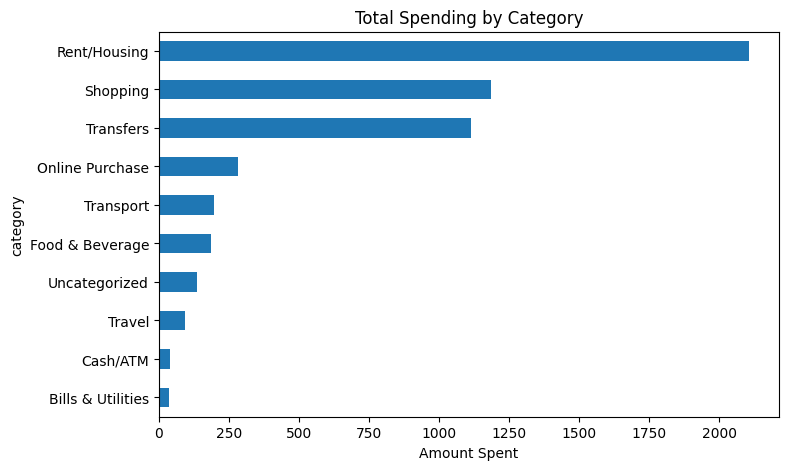

,amount
category,
Bills & Utilities,38.00
Cash/ATM,40.00
Travel,93.34
Uncategorized,137.50
Food & Beverage,187.35
Transport,198.40
Online Purchase,282.50
Transfers,1113.74
Shopping,1185.73


In [ ]:
# Spending by category
# Filter only expenses (amount < 0), flip to positive
cat_summary = (
    transactions[transactions["type"] == "Expense"]
    .groupby("category")["amount"]
    .sum()
    .abs()                     # turn negatives into positives
    .sort_values()
)

# Plot
cat_summary.plot(kind="barh", title="Total Spending by Category", figsize=(8,5))
plt.xlabel("Amount Spent")
plt.show()

# Show table too
cat_summary

**Monthly Trends**

<Axes: title={'center': 'Monthly Income vs Expense'}, xlabel='year_month'>

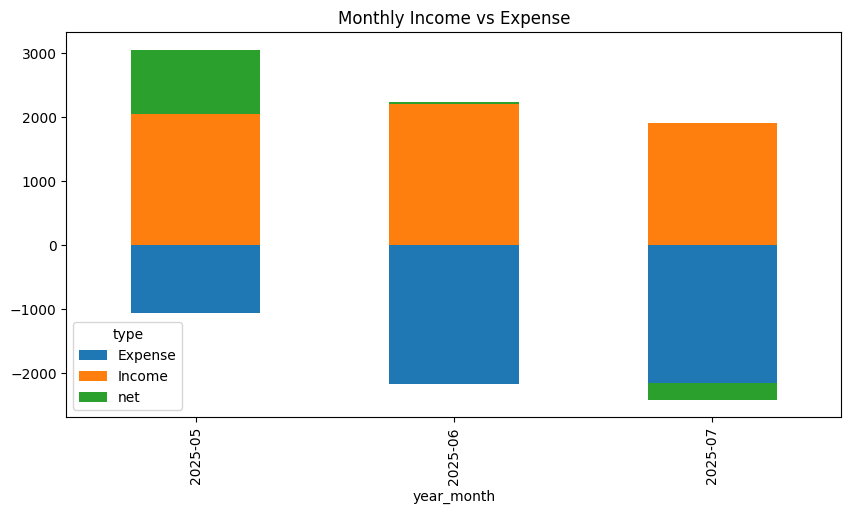

In [ ]:
transactions["year_month"] = pd.to_datetime(transactions["date"]).dt.to_period("M").astype(str)

monthly = (transactions
           .groupby(["year_month","type"])["amount"]
           .sum()
           .unstack(fill_value=0))

monthly["net"] = monthly["Income"] + monthly["Expense"]
monthly.plot(kind="bar", stacked=True, figsize=(10,5), title="Monthly Income vs Expense")


**Daily Cashflow**

<Axes: title={'center': 'Daily Cashflow'}, xlabel='date'>

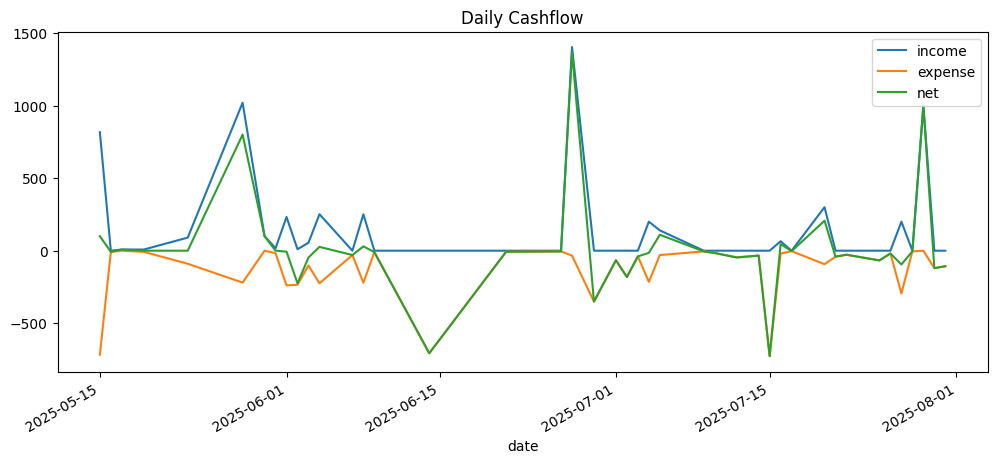

In [ ]:
daily.set_index("date")[["income","expense","net"]].plot(figsize=(12,5), title="Daily Cashflow")

**Big Expenses**

In [ ]:
big_exp = transactions[transactions["big_expense"]==True]
print("Big expenses found:", len(big_exp))
big_exp.sort_values("amount").head(10)

Big expenses found: 13


,seq,date,raw_description,clean_description,category,type,amount,big_expense,balance,year_month
43,44,2025-06-14,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,TRANSFER FR RAMADHAN MOCHAMAD R,Rent/Housing,Expense,-707.16,True,32.84,2025-06
4,5,2025-05-15,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,TRANSFER FR RAMADHAN MOCHAMAD R,Rent/Housing,Expense,-700.00,True,100.00,2025-05
71,72,2025-07-15,TRANSFER FR A/C | RAMADHAN MOCHAMAD R*,TRANSFER FR RAMADHAN MOCHAMAD R,Rent/Housing,Expense,-700.00,True,20.38,2025-07
50,51,2025-06-29,TRANSFER FR A/C | MOHAMMAD JAVAN SAMB*,TRANSFER FR MOHAMMAD JAVAN SAMB,Transfers,Expense,-300.00,True,1090.84,2025-06
21,22,2025-06-01,PRE-AUTH DEBIT | STEAMGAMES.COM 4259*,STEAMGAMES.,Online Purchase,Expense,-232.60,True,767.41,2025-06
40,41,2025-06-08,PAYMENT VIA MYDEBIT | PUBLIC BANK BERHAD *,PUBLIC BANK BERHAD,Shopping,Expense,-211.00,True,499.10,2025-06
15,16,2025-05-28,TRANSFER FR A/C | MOHAMMAD JAVAN SAMB*,TRANSFER FR MOHAMMAD JAVAN SAMB,Transfers,Expense,-200.00,True,900.00,2025-05
59,60,2025-07-04,PRE-AUTH DEBIT | PSS-SRI KEMBANGAN *,PSS-SRI KEMBANGAN,Shopping,Expense,-200.00,True,553.33,2025-07
85,86,2025-07-27,SALE DEBIT | Shopee Malaysia *,Shopee Malaysia,Shopping,Expense,-184.60,True,40.09,2025-07
34,35,2025-06-04,SALE DEBIT | Shopee Malaysia *,Shopee Malaysia,Shopping,Expense,-174.00,True,498.59,2025-06


**Day of Week Behavior**

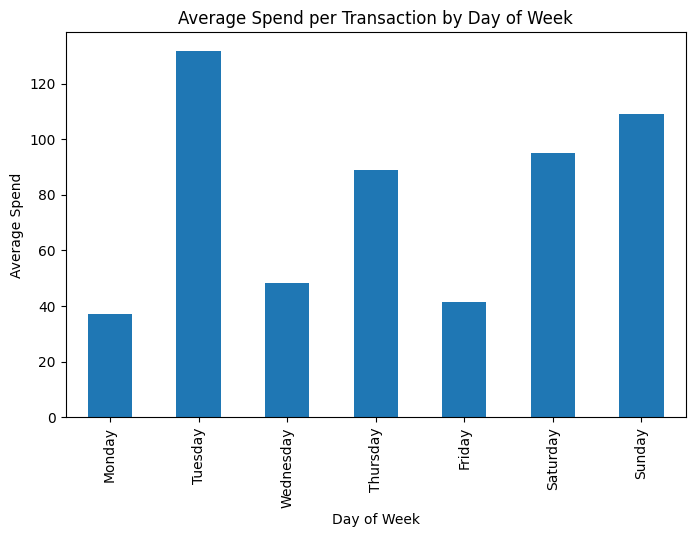

,amount_pos
Day of Week,
Monday,36.943333
Tuesday,131.857143
Wednesday,48.200000
Thursday,88.743000
Friday,41.380000
Saturday,95.173333
Sunday,109.021818


In [ ]:
# Ensure weekday column exists
transactions["Day of Week"] = pd.to_datetime(transactions["date"]).dt.day_name()

# Expenses only
expenses = transactions[transactions["type"] == "Expense"].copy()
expenses["amount_pos"] = expenses["amount"].abs()

# Average spend per transaction by weekday
avg_spend = (
    expenses.groupby("Day of Week")["amount_pos"]
    .mean()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
)

# Plot
avg_spend.plot(kind="bar", title="Average Spend per Transaction by Day of Week", figsize=(8,5))
plt.ylabel("Average Spend")
plt.show()

avg_spend

# **Predictive Modeling**

In [14]:
daily = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Finance Tracker/daily_aggregate.csv", parse_dates=["date"])
daily = daily.set_index("date").sort_index()

# Focus on net (can also try 'expense' alone)
y = daily["expense"].abs()

y.tail()

,expense
date,
2025-07-27,294.7
2025-07-28,5.0
2025-07-29,0.0
2025-07-30,120.3
2025-07-31,107.3


In [15]:
def adf_pvalue(series):
    series = series.dropna()
    return adfuller(series)[1]

pval = adf_pvalue(y)
print("ADF p-value (original):", round(pval, 4))

# If not stationary, try first difference
if pval > 0.05:
    yd = y.diff().dropna()
    pval_d = adf_pvalue(yd)
    print("ADF p-value (1st diff):", round(pval_d, 4))
    use_d = 1 if pval_d < 0.05 else 2
else:
    use_d = 0

print("Chosen differencing d =", use_d)


ADF p-value (original): 0.0
Chosen differencing d = 0


In [16]:
warnings.filterwarnings("ignore")

def fit_arima(y, p, d, q):
    try:
        model = ARIMA(y, order=(p,d,q))
        res = model.fit()
        return res
    except Exception:
        return None

cand_p = range(0, 4)  # 0..3
cand_q = range(0, 4)  # 0..3
best = {"aic": np.inf, "order": None, "res": None}

for p in cand_p:
    for q in cand_q:
        res = fit_arima(y, p, use_d, q)
        if res is not None and res.aic < best["aic"]:
            best = {"aic": res.aic, "order": (p,use_d,q), "res": res}

print("Best order by AIC:", best["order"], "AIC:", round(best["aic"], 2))
results = best["res"]


Best order by AIC: (0, 0, 1) AIC: 560.94


Forecasting Next 30 Days

In [17]:
n_periods = 30
fc = results.get_forecast(steps=n_periods)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

# Build frame with dates
future_idx = pd.date_range(y.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq="D")
fc_df = pd.DataFrame({
    "forecast": fc_mean.values,
    "lower": fc_ci.iloc[:,0].values,
    "upper": fc_ci.iloc[:,1].values
}, index=future_idx)

fc_df.head()


,forecast,lower,upper
2025-08-01,143.595825,-206.421561,493.613211
2025-08-02,123.399296,-258.079894,504.878487
2025-08-03,123.399296,-258.079894,504.878487
2025-08-04,123.399296,-258.079894,504.878487
2025-08-05,123.399296,-258.079894,504.878487


**Plotting**

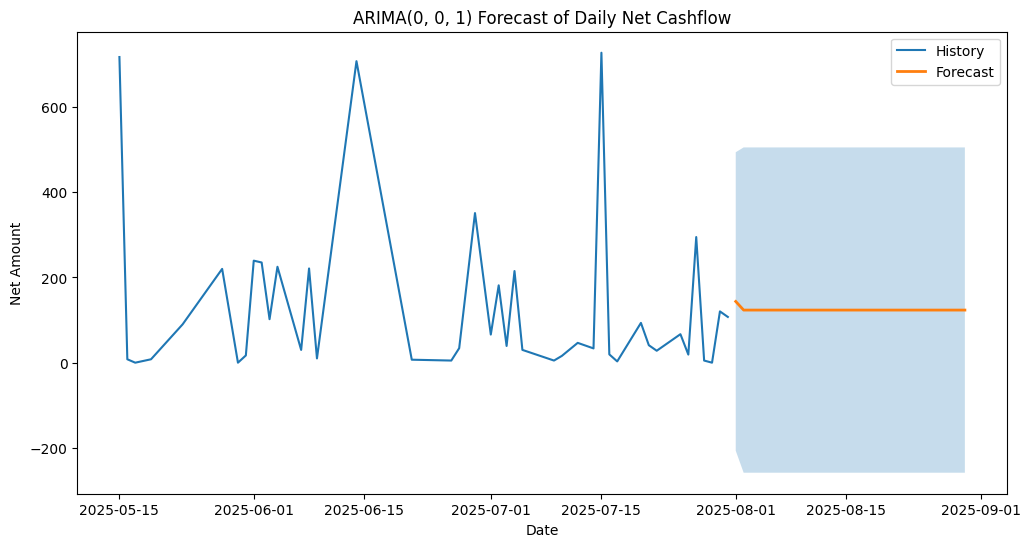

In [18]:
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="History")
plt.plot(fc_df.index, fc_df["forecast"], label="Forecast", linewidth=2)
plt.fill_between(fc_df.index, fc_df["lower"], fc_df["upper"], alpha=0.25)
plt.title(f"ARIMA{best['order']} Forecast of Daily Net Cashflow")
plt.xlabel("Date"); plt.ylabel("Net Amount")
plt.legend(); plt.show()
